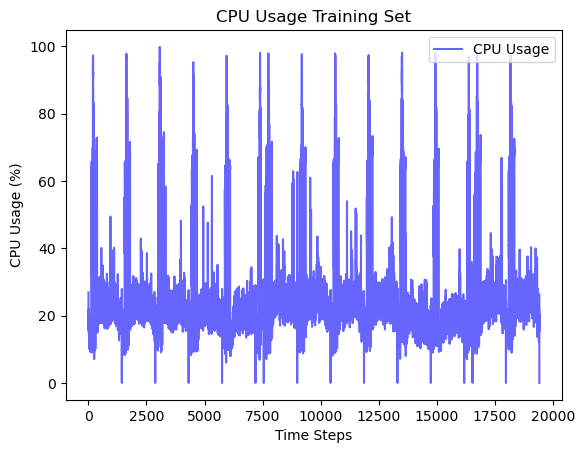

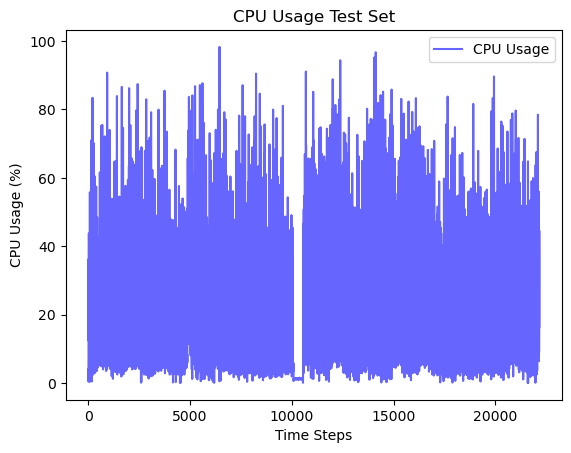

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import *
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from scipy import interpolate
import json
from pathlib import Path
from pandas import to_numeric

def create_time_features(data):
    # Assume 'cpu_data' is your dataframe and 'datetime' is the column with datetime values
    data['datetime'] = pd.to_datetime(data['datetime'])  # Ensure it's a datetime type
    data['hour'] = data['datetime'].dt.hour
    data['day_of_week'] = data['datetime'].dt.dayofweek
    data['month'] = data['datetime'].dt.month
    data['day_of_month'] = data['datetime'].dt.day
    data['is_weekend'] = data['datetime'].dt.weekday >= 5  # True for Saturday and Sunday
    return data

cpu_data = pd.read_csv('../Utilities\csv\cpu_usage_data_train.csv')
cpu_data = create_time_features(cpu_data)
test_data = pd.read_csv('../Utilities/csv/cpu_usage_data_test.csv')
test_data['datetime'] = pd.to_datetime(test_data['datetime'])
test_data.set_index('datetime', inplace=True)
test_data = test_data.sort_index()
test_data_resampled = test_data.resample('T').asfreq()
test_data_resampled[['cpu_usage']] = test_data_resampled[['cpu_usage']].interpolate(method='cubic')
test_data.reset_index(inplace=True)
test_data_resampled.reset_index(inplace=True)
test_data = create_time_features(test_data_resampled)
test_data_cleaned = test_data[(test_data[['cpu_usage']] >= 0).all(axis=1)].copy()
test_data_cleaned = test_data_cleaned[(test_data_cleaned[['cpu_usage']] <= 100).all(axis=1)].copy()

file_path = "../Utilities/csv/cpu_usage_train.csv"
cpu_data.to_csv(file_path, index=False)

file_path = "../Utilities/csv/cpu_usage_test.csv"
test_data_cleaned.to_csv(file_path, index=False)

plt.plot(cpu_data['cpu_usage'], label='CPU Usage', color='blue', alpha=0.6)
plt.title('CPU Usage Training Set')
plt.xlabel('Time Steps')
plt.ylabel('CPU Usage (%)')
plt.legend(loc='upper right')
plt.show()

plt.plot(test_data_cleaned['cpu_usage'], label='CPU Usage', color='blue', alpha=0.6)
plt.title('CPU Usage Test Set')
plt.xlabel('Time Steps')
plt.ylabel('CPU Usage (%)')
plt.legend(loc='upper right')
plt.show()

In [19]:
# Load your data
cpu_data = pd.read_csv('../Utilities/csv/cpu_usage_train.csv')

# Parse the datetime column
cpu_data['datetime'] = pd.to_datetime(cpu_data['datetime'])

# Drop datetime column if needed
cpu_data = cpu_data.drop(columns=['datetime'])

# Separate features and target before scaling
features = cpu_data.drop(columns=['cpu_usage'])  # Assuming 'cpu_usage' is the target column
target = cpu_data[['cpu_usage']]  # The target column

# Scale features and target separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)

# Use `X_scaled` and `y_scaled` for creating sequences


def create_sequences_multi_step(X_data, y_data, seq_length, pred_steps):
    X_sequences, y_sequences = [], []
    for i in range(len(X_data) - seq_length - pred_steps + 1):
        # Input sequences: last 'seq_length' timesteps of features
        X_sequences.append(X_data[i:i + seq_length])  # Shape will be (seq_length, n_features)
        # Labels: next 'pred_steps' values of the target feature
        y_sequences.append(y_data[i + seq_length:i + seq_length + pred_steps, 0])  # Predicting the next 10 values for the target feature 
    return np.array(X_sequences), np.array(y_sequences)


# In 10 minute increments
prediction_steps = 10
prediction_lookup = 60
X_seq, y_seq = create_sequences_multi_step(X_scaled, y_scaled, prediction_lookup, prediction_steps)

print("X_seq shape:", X_seq.shape)  # Should be (n_samples, seq_length, n_features)
print("y_seq shape:", y_seq.shape)  # Should be (n_samples, 10) for one feature

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, activation='relu', return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(prediction_steps))

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
history = lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping, model_checkpoint])

mse_lstm = lstm_model.evaluate(X_test, y_test)
rmse_lstm = np.sqrt(mse_lstm)

print(f"RMSE: {rmse_lstm}, MSE: {mse_lstm}")

X_seq shape: (19356, 60, 5)
y_seq shape: (19356, 10)
Epoch 1/50
484/484 [==============================] - ETA: 0s - loss: 0.0255
Epoch 1: val_loss improved from inf to 0.02164, saving model to best_model.hdf5
484/484 [==============================] - 99s 184ms/step - loss: 0.0255 - val_loss: 0.0216
Epoch 2/50


c:\Users\brand\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


484/484 [==============================] - ETA: 0s - loss: 0.0209
Epoch 2: val_loss improved from 0.02164 to 0.01380, saving model to best_model.hdf5
484/484 [==============================] - 87s 180ms/step - loss: 0.0209 - val_loss: 0.0138
Epoch 3/50
484/484 [==============================] - ETA: 0s - loss: 0.0144
Epoch 3: val_loss improved from 0.01380 to 0.01238, saving model to best_model.hdf5
484/484 [==============================] - 89s 184ms/step - loss: 0.0144 - val_loss: 0.0124
Epoch 4/50
484/484 [==============================] - ETA: 0s - loss: 0.0141
Epoch 4: val_loss improved from 0.01238 to 0.01175, saving model to best_model.hdf5
484/484 [==============================] - 83s 172ms/step - loss: 0.0141 - val_loss: 0.0117
Epoch 5/50
484/484 [==============================] - ETA: 0s - loss: 0.0131
Epoch 5: val_loss improved from 0.01175 to 0.01045, saving model to best_model.hdf5
484/484 [==============================] - 87s 179ms/step - loss: 0.0131 - val_loss: 0.0105

121/121 [==============================] - 8s 51ms/step
RMSE: 2.836669285442768, MSE: 8.046692634974384


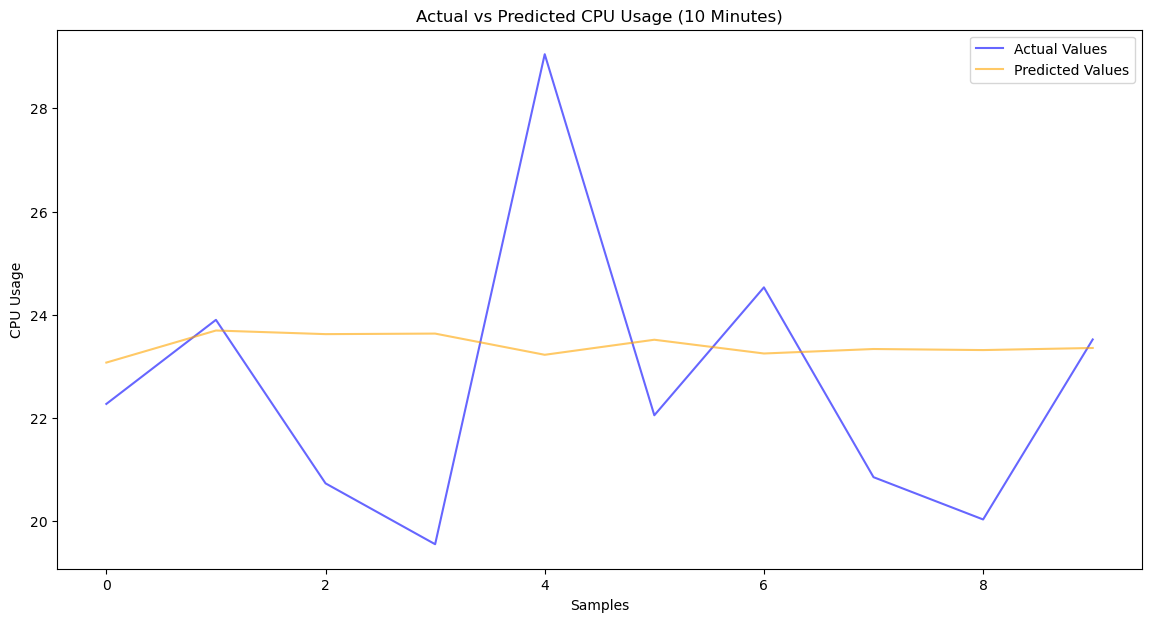

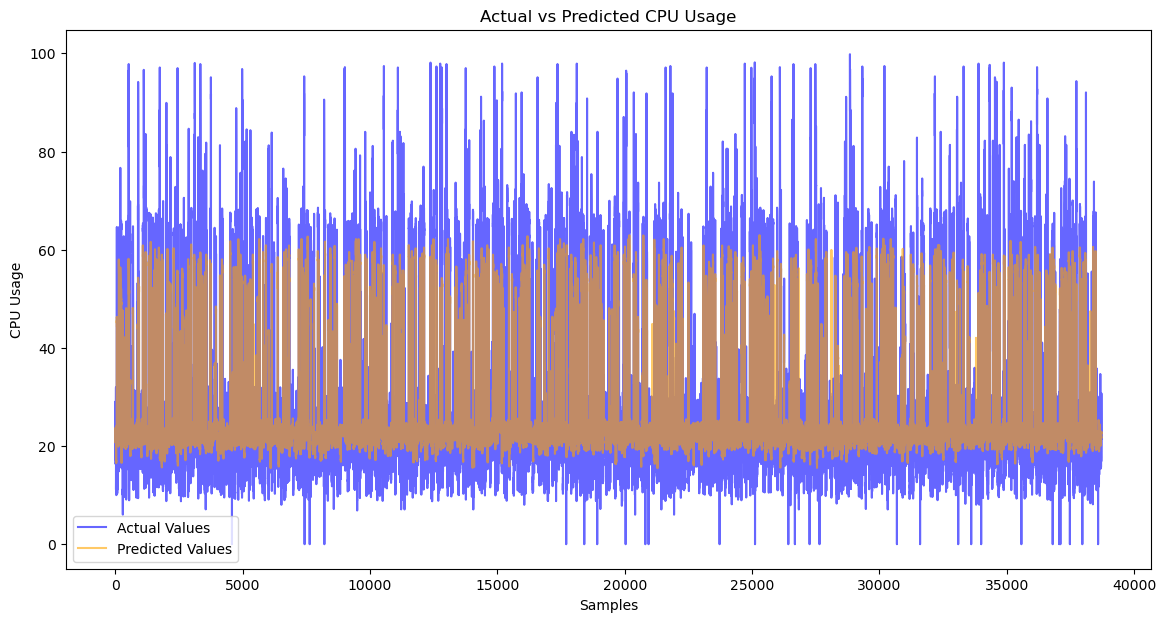

In [20]:
# Make predictions
y_pred = lstm_model.predict(X_test)

# Inverse transform the predictions using the target scaler
y_pred_unscaled = target_scaler.inverse_transform(y_pred)

# If `y_test` also needs inverse transforming
y_test_unscaled = target_scaler.inverse_transform(y_test)


# Calculate MSE and RMSE
mse_lstm = mean_squared_error(y_test_unscaled[0], y_pred_unscaled[0])
rmse_lstm = np.sqrt(mse_lstm)

print(f"RMSE: {rmse_lstm}, MSE: {mse_lstm}")

# Plotting Actual vs Predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_unscaled[0], label='Actual Values', color='blue', alpha=0.6)
plt.plot(y_pred_unscaled[0], label='Predicted Values', color='orange', alpha=0.6)
plt.title('Actual vs Predicted CPU Usage (10 Minutes)')
plt.xlabel('Samples')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()

# Plotting Actual vs Predicted values
y_test_rescaled_flat = y_test_unscaled.flatten()
predictions_rescaled_flat = y_pred_unscaled.flatten()
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled_flat, label='Actual Values', color='blue', alpha=0.6)
plt.plot(predictions_rescaled_flat, label='Predicted Values', color='orange', alpha=0.6)
plt.title('Actual vs Predicted CPU Usage')
plt.xlabel('Samples')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()
